## GoK Huduma Satisfaction Prediction Model

### Modeling Objectives
- Train and evaluate classification models to predict satisfaction
- Use SHAP to explain key satisfaction drivers
- Monitor performance using recall, F1 and AUC scores
- Handle class imbalance and feature engineering

The notebook presents a comprehensive machine learning pipeline for predicting customer satisfaction. It begins with data preprocessing, including feature engineering, encoding, and scaling, followed by addressing class imbalance using SMOTE. The pipeline explores and compares multiple models—Random Forest, Gradient Boosting, and Logistic Regression—evaluated primarily through recall, F1-score, and AUC metrics. Feature importance analysis highlights key drivers influencing satisfaction, while model interpretability is enhanced using SHAP and Yellowbrick libraries. Among the tested models, Random Forest demonstrated the strongest performance, particularly in recall and AUC, making it the preferred choice for deployment in the customer satisfaction prediction system.

In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

In [2]:
# Loading and exploring the data
df = pd.read_csv('eda_incl.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values:\n{df.isnull().sum()}")
df.head()

Dataset shape: (364689, 14)

Columns: ['Agency Name', 'Complaint Type', 'Descriptor', 'Borough', 'Resolution Description', 'Survey Year', 'Survey Month', 'Satisfaction Response', 'Dissatisfaction Reason', 'Justified Dissatisfaction', 'Cluster', 'Combined_Feedback', 'Sentiment Score', 'Sentiment Label']

Missing values:
Agency Name                  0
Complaint Type               0
Descriptor                   0
Borough                      0
Resolution Description       0
Survey Year                  0
Survey Month                 0
Satisfaction Response        0
Dissatisfaction Reason       0
Justified Dissatisfaction    0
Cluster                      0
Combined_Feedback            0
Sentiment Score              0
Sentiment Label              0
dtype: int64


,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Survey Year,Survey Month,Satisfaction Response,Dissatisfaction Reason,Justified Dissatisfaction,Cluster,Combined_Feedback,Sentiment Score,Sentiment Label
0,Department of Buildings,Adult Establishment,Zoning Violation,MANHATTAN,The Department of Buildings investigated this ...,2022,10,Strongly Agree,Not Applicable,Delays in inspections or provision of construc...,0,Delays in inspections or provision of construc...,0.0000,neutral
1,Department of Buildings,Adult Establishment,Zoning Violation,BROOKLYN,The Department of Buildings investigated this ...,2024,11,Strongly Disagree,The Agency did not correct the issue.,Delays in inspections or provision of construc...,1,Delays in inspections or provision of construc...,0.0000,neutral
2,Department for the Aging,Legal Services Provider Complaint,Not Provided,MANHATTAN,The Department for the Aging contacted you and...,2024,3,Strongly Agree,Not Applicable,Lack of timely support or services for senior ...,0,Lack of timely support or services for senior ...,0.1027,positive
3,Department of Buildings,Advertising Sign,Poster,MANHATTAN,The Department of Buildings reviewed this comp...,2024,2,Neutral,Not Applicable,Delays in inspections or provision of construc...,0,Delays in inspections or provision of construc...,0.0000,neutral
4,Department of Buildings,Advertising Sign,Billboard,MANHATTAN,The Department of Buildings investigated this ...,2023,10,Strongly Disagree,"Status updates were unhelpful, inaccurate, inc...",Delays in inspections or provision of construc...,3,Delays in inspections or provision of construc...,0.0000,neutral


Class distribution:
0    0.665545
1    0.334455
Name: Satisfied, dtype: float64


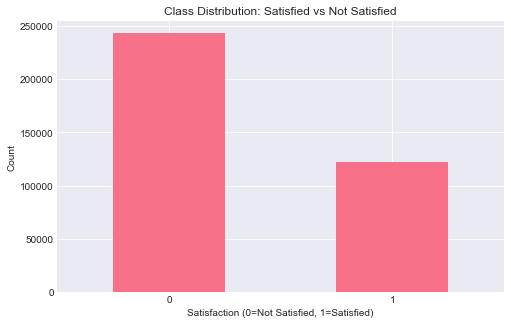

In [3]:
# Creating binary satisfaction target
satisfaction_mapping = {
    'Strongly Agree': 1,
    'Agree': 1,
    'Neutral': 0,
    'Disagree': 0,
    'Strongly Disagree': 0
}

df['Satisfied'] = df['Satisfaction Response'].map(satisfaction_mapping)

# Check class distribution
print("Class distribution:")
print(df['Satisfied'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['Satisfied'].value_counts().plot(kind='bar')
plt.title('Class Distribution: Satisfied vs Not Satisfied')
plt.xlabel('Satisfaction (0=Not Satisfied, 1=Satisfied)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show(); 

### Feature Engineering

In [4]:
# Creating new features
df['resolution_length'] = df['Resolution Description'].str.len()
df['dissatisfaction_reason_provided'] = (df['Dissatisfaction Reason'] != 'Not Applicable').astype(int)
df['sentiment_positive'] = (df['Sentiment Label'] == 'positive').astype(int)
df['sentiment_negative'] = (df['Sentiment Label'] == 'negative').astype(int)

# Select features for modeling
categorical_features = ['Agency Name', 'Complaint Type', 'Borough', 'Sentiment Label']
numerical_features = ['Survey Year', 'Survey Month', 'Cluster', 'Sentiment Score', 
                     'resolution_length', 'dissatisfaction_reason_provided', 
                     'sentiment_positive', 'sentiment_negative']

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

Categorical features: ['Agency Name', 'Complaint Type', 'Borough', 'Sentiment Label']
Numerical features: ['Survey Year', 'Survey Month', 'Cluster', 'Sentiment Score', 'resolution_length', 'dissatisfaction_reason_provided', 'sentiment_positive', 'sentiment_negative']


### Data Preprocessing Pipeline

In [5]:
# Handle missing values
for col in categorical_features:
    df[col] = df[col].fillna('Unknown')

for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare feature matrix
encoded_categorical = [f'{col}_encoded' for col in categorical_features]
all_features = numerical_features + encoded_categorical

X = df[all_features]
y = df['Satisfied']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")

Feature matrix shape: (364689, 12)
Target distribution: 0    242717
1    121972
Name: Satisfied, dtype: int64


### Train/Validation/Test Split

In [6]:
# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set: (218813, 12)
Validation set: (72938, 12)
Test set: (72938, 12)


### Handling Class Imbalance

In [7]:
# Applying SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set distribution: {y_train.value_counts()}")
print(f"Balanced training set distribution: {pd.Series(y_train_balanced).value_counts()}")

Original training set distribution: 0    145630
1     73183
Name: Satisfied, dtype: int64
Balanced training set distribution: 0    145630
1    145630
Name: Satisfied, dtype: int64


### Model Training and Evaluation

In [8]:
# Initializing models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Training and evaluating models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_balanced, y_train_balanced)
    trained_models[name] = model
    
    # Predictions
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {
        'Recall': recall,
        'F1': f1,
        'AUC': auc
    }
    
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

# Results summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)


Training Random Forest...
Recall: 0.974
F1 Score: 0.924
AUC Score: 0.973

Training XGBoost...
Recall: 1.000
F1 Score: 0.933
AUC Score: 0.977

Training Logistic Regression...
Recall: 1.000
F1 Score: 0.933
AUC Score: 0.972

Model Performance Summary:
                       Recall        F1       AUC
Random Forest        0.973929  0.924115  0.972931
XGBoost              1.000000  0.933226  0.977140
Logistic Regression  0.999959  0.933242  0.972048


### Cross-Validation

In [9]:
# Cross-validation with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')
    cv_results[name] = {
        'Mean AUC': cv_scores.mean(),
        'Std AUC': cv_scores.std()
    }
    print(f"{name} - CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results:")
print(cv_df)

Random Forest - CV AUC: 0.975 (+/- 0.002)
XGBoost - CV AUC: 0.977 (+/- 0.001)
Logistic Regression - CV AUC: 0.971 (+/- 0.002)

Cross-Validation Results:
                     Mean AUC   Std AUC
Random Forest        0.975194  0.000984
XGBoost              0.976871  0.000701
Logistic Regression  0.970980  0.001113


### Feature Importance Visualization

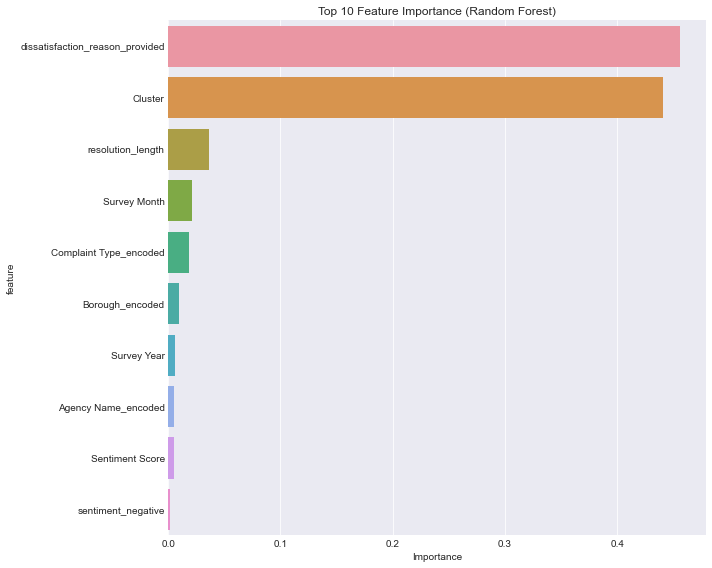

Top 10 Most Important Features:
                            feature  importance
5   dissatisfaction_reason_provided    0.455813
2                           Cluster    0.440483
4                 resolution_length    0.036640
1                      Survey Month    0.020932
9            Complaint Type_encoded    0.018090
10                  Borough_encoded    0.009413
0                       Survey Year    0.005879
8               Agency Name_encoded    0.005347
3                   Sentiment Score    0.005116
7                sentiment_negative    0.001394


In [10]:
# Feature importance for Random Forest
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

### Yellowbrick Visualization for Model Interpretability

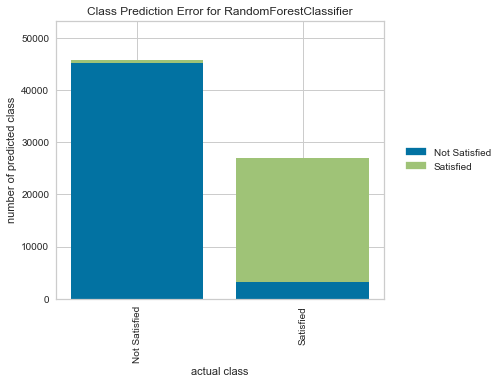

In [26]:
# Importing Yellowbrick visualizer
from yellowbrick.classifier import ClassPredictionError

# Class Prediction Error
cpe = ClassPredictionError(trained_models['Random Forest'], classes=['Not Satisfied', 'Satisfied'])
cpe.fit(X_train_balanced, y_train_balanced)
cpe.score(X_val_scaled, y_val)
cpe.show(); 

### SHAP Analysis for Model Interpretability

In [11]:
# SHAP analysis for Random Forest (best performing model)
best_model = trained_models['Random Forest']

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_scaled[:1000])  # Use subset for performance

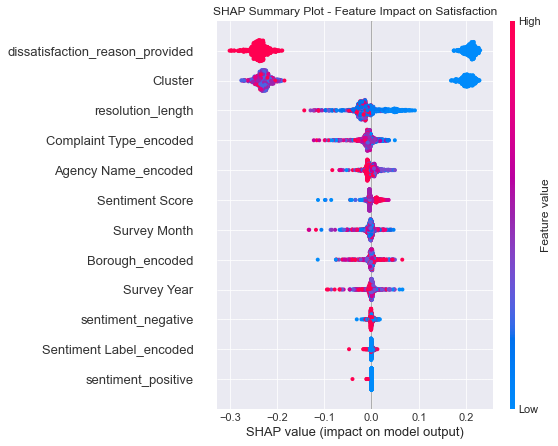

In [12]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], X_val_scaled[:1000], feature_names=all_features, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Satisfaction')
plt.tight_layout()
plt.show(); 

### Final Model Evaluation on Test Set

In [23]:
# Evaluate best model on test set
best_model = trained_models['Random Forest']
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate final metrics
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print("Final Test Set Performance:")
print(f"Recall: {test_recall:.3f}")
print(f"F1 Score: {test_f1:.3f}")
print(f"AUC Score: {test_auc:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Final Test Set Performance:
Recall: 0.970
F1 Score: 0.921
AUC Score: 0.972

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     48544
           1       0.88      0.97      0.92     24394

    accuracy                           0.94     72938
   macro avg       0.93      0.95      0.94     72938
weighted avg       0.95      0.94      0.94     72938



In [24]:
# Import joblib for model persistence
import joblib

# Save the best model to disk
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']